In [1]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import haversine_distances
import pandas
import tweetdf
import geopandas
import regions
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np
import importlib
from shapely.geometry import Polygon
importlib.reload(regions)

<module 'regions' from '/Users/ericwennerberg/source/chalmers/mscthesis/src/py/regions.py'>

In [2]:
tweets = tweetdf.from_csv("../../dbs/Sweden.csv")

In [3]:
tweets.head()

,userid,tweetid,createdat,latitude,longitude,month,weekday,hourofday,timezone
0,14153467,24287237314,2010-09-12 16:23:34+02:00,59.622270,16.503370,9.0,0.0,16.0,Europe/Stockholm
1,34262938,24291802016,2010-09-12 17:21:16+02:00,59.401982,17.987409,9.0,0.0,17.0,Europe/Stockholm
2,91627942,24297613406,2010-09-12 18:35:10+02:00,55.605118,13.024249,9.0,0.0,18.0,Europe/Stockholm
3,91627942,24373283508,2010-09-13 13:13:41+02:00,55.705907,13.192397,9.0,1.0,13.0,Europe/Stockholm
4,14153467,24373939933,2010-09-13 13:25:42+02:00,59.611300,16.549830,9.0,1.0,13.0,Europe/Stockholm


In [253]:
topusers = tweets.groupby('userid', as_index=False).count()[['userid', 'tweetid']].rename(columns={'tweetid': 'count'})
topusers = topusers.sort_values(by='count', ascending=False).head(10)
print(topusers)
tweetsm = topusers.merge(tweets, on='userid')
tweetsm = geopandas.GeoDataFrame(
    tweetsm,
    crs="EPSG:4326",
    geometry=geopandas.points_from_xy(tweetsm.longitude, tweetsm.latitude),
)

          userid  count
86      14151819   4778
1559   209618294   4644
2321   457366591   3644
652     35603037   3320
542     28485887   3298
2896  1087209600   3261
719     40761393   3249
2066   375748207   3223
3157  2286335813   3075
2683   631831446   3069


In [254]:
tweetsm.head()

,userid,count,tweetid,createdat,latitude,longitude,month,weekday,hourofday,timezone,geometry
0,14151819,4778,701442216120688641,2016-02-21 17:23:51+01:00,59.3183,18.0699,2.0,0.0,17.0,Europe/Stockholm,POINT (18.06990 59.31830)
1,14151819,4778,702507656859283456,2016-02-24 15:57:32+01:00,59.3196,18.0689,2.0,3.0,15.0,Europe/Stockholm,POINT (18.06890 59.31960)
2,14151819,4778,702526815684972545,2016-02-24 17:13:39+01:00,59.3196,18.0689,2.0,3.0,17.0,Europe/Stockholm,POINT (18.06890 59.31960)
3,14151819,4778,702535969845731329,2016-02-24 17:50:02+01:00,59.3196,18.0689,2.0,3.0,17.0,Europe/Stockholm,POINT (18.06890 59.31960)
4,14151819,4778,702543931033182209,2016-02-24 18:21:40+01:00,59.3196,18.0689,2.0,3.0,18.0,Europe/Stockholm,POINT (18.06890 59.31960)


In [323]:
usertweets = tweetsm[tweetsm['userid'] == 1087209600].reset_index()

In [324]:
coords = usertweets[['latitude', 'longitude']].values
kms_per_radian = 6371.0088
dbs = DBSCAN(eps=0.01/kms_per_radian, min_samples=1, metric='haversine').fit(np.radians(coords))

In [329]:
s = pandas.Series(dbs.labels_)
print(s)
maxidx = s.groupby(s).size().argmax()
print(maxidx)
print(s == maxidx)
usertweets
usertweets[s == maxidx].head(1)

0         0
1         1
2         1
3         2
4         3
       ... 
3256    795
3257    795
3258    838
3259    720
3260    720
Length: 3261, dtype: int64
9
0       False
1       False
2       False
3       False
4       False
        ...  
3256    False
3257    False
3258    False
3259    False
3260    False
Length: 3261, dtype: bool


,index,userid,count,tweetid,createdat,latitude,longitude,month,weekday,hourofday,timezone,geometry,cluster,cluster_size
25,19695,1087209600,3261,454628657588604929,2014-04-11 16:34:53+02:00,59.334372,18.070566,4.0,5.0,16.0,Europe/Stockholm,POINT (18.07057 59.33437),5,115


In [326]:
usertweets = usertweets.assign(cluster=pandas.Series(dbs.labels_, index=usertweets.index).values)
usertweets = usertweets.merge(
    pandas.DataFrame(usertweets.groupby('cluster').size()).rename(columns={0: 'cluster_size'}), 
    on='cluster',
)

In [327]:
usertweets.head()

,index,userid,count,tweetid,createdat,latitude,longitude,month,weekday,hourofday,timezone,geometry,cluster,cluster_size
0,19684,1087209600,3261,453143878531817472,2014-04-07 14:14:54+02:00,59.291827,18.082493,4.0,1.0,14.0,Europe/Stockholm,POINT (18.08249 59.29183),0,1
1,19685,1087209600,3261,453151801576259585,2014-04-07 14:46:23+02:00,59.290677,18.083968,4.0,1.0,14.0,Europe/Stockholm,POINT (18.08397 59.29068),1,2
2,19686,1087209600,3261,453162399450021888,2014-04-07 15:28:30+02:00,59.290677,18.083968,4.0,1.0,15.0,Europe/Stockholm,POINT (18.08397 59.29068),1,2
3,19687,1087209600,3261,453165407730688000,2014-04-07 15:40:27+02:00,59.291244,18.084061,4.0,1.0,15.0,Europe/Stockholm,POINT (18.08406 59.29124),2,1
4,19688,1087209600,3261,453578632699846656,2014-04-08 19:02:27+02:00,59.323159,18.001959,4.0,2.0,19.0,Europe/Stockholm,POINT (18.00196 59.32316),3,18


In [279]:
usertweets.groupby('cluster').size()

cluster
0       1
1       2
2       1
3      18
4       1
       ..
834     1
835     1
836     1
837     1
838     1
Length: 839, dtype: int64

In [272]:
def plot_clusters(tweets, cluster=None):
    tweets2 = None
    if cluster is not None:
        tweets2 = tweets[tweets['cluster'] == cluster]
    else:
        tweets2 = tweets
    tmp_bounds = tweets2.total_bounds
    bounds = geopandas.GeoSeries([Polygon([
        (tmp_bounds[0], tmp_bounds[1]), # lower left
        (tmp_bounds[2], tmp_bounds[1]), # upper left
        (tmp_bounds[2], tmp_bounds[3]), # upper right
        (tmp_bounds[0], tmp_bounds[3]), # lower right
    ])]).scale(1.2,1.2)
    countries_user = geopandas.clip(regions.countries_wgs, bounds)
    ax = tweets2.plot(column='cluster', cmap='Dark2', markersize=1)
    countries_user.plot(ax=ax, facecolor='none', edgecolor='black')

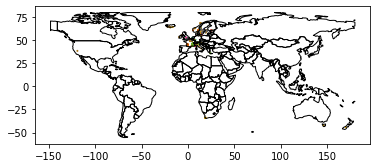

In [280]:
plot_clusters(usertweets)

In [251]:
def plot_cluster_distrib(tweets):
    weekdays = tweets[(tweets['weekday'] < 6) & (0 < tweets['weekday'])]
    weekends = tweets[(tweets['weekday'] == 6) | (0 == tweets['weekday'])]
    fig, axes = plt.subplots(2,2, figsize = (15,15))
    
    for i, t in zip([0,1], [weekdays, weekends]):
        axes[0, i].hist2d(t['hourofday'], 
            t['cluster'], 
            #norm=pltcolors.LogNorm(),
            #density=True, 
            cmap='viridis',
            bins=(24, len(t['cluster'].unique())),
        )
        t.groupby(['hourofday', 'cluster']).size().unstack().fillna(0).plot(ax=axes[1,i])
    

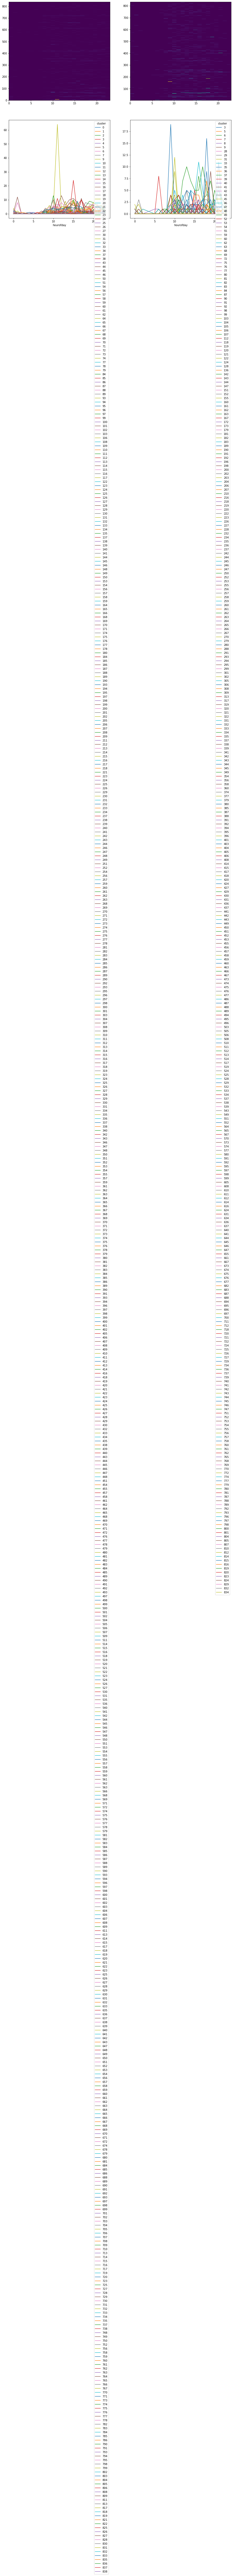

In [281]:
plot_cluster_distrib(usertweets)

In [240]:
usertweets = usertweets.sort_values('hourofday')

1

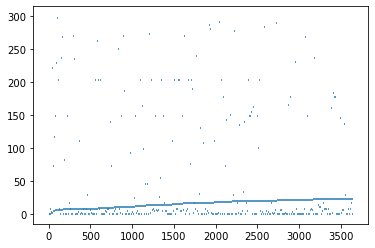

In [241]:
plt.eventplot(np.array(usertweets[['hourofday', 'cluster']]), orientation='vertical')
1

(array([284.,   6.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   3.,   1.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.00000e+00, 1.49700e+01, 2.89400e+01, 4.29100e+01, 5.68800e+01,
        7.08500e+01, 8.48200e+01, 9.87900e+01, 1.12760e+02, 1.26730e+02,
        1.40700e+02, 1.54670e+02, 1.68640e+02, 1.82610e+02, 1.96580e+02,
        2.10550e+02, 2.24520e+02, 2.38490e+02, 2.52460e+02, 2.66430e+02,
        2.80400e+02, 2.943

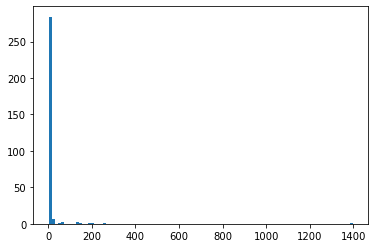

In [242]:
plt.hist(usertweets.groupby('cluster').size(), bins=100)